In [125]:
!pip install catboost --quiet

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [127]:
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

Задача: определить температуру процесса

Предобработка

In [128]:
data = pd.read_csv('/content/MaintenanceR.csv')

In [129]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [130]:
(data.isna().sum()).sort_values(ascending=False)

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [131]:
data.duplicated().sum()

np.int64(0)

In [132]:
data.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


In [133]:
data = data.drop(columns=['UDI', 'Product ID'])

In [134]:
data['Type'] = pd.factorize(data['Type'])[0]

In [135]:
data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,2,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,0,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,2,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [136]:
data.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.80060,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,0.60023,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,0.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.00000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.00000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Вывод: у температур небольшое среднее отклонение, значит нет резких перепадов и больше всего первых типов продукта

Визуализация

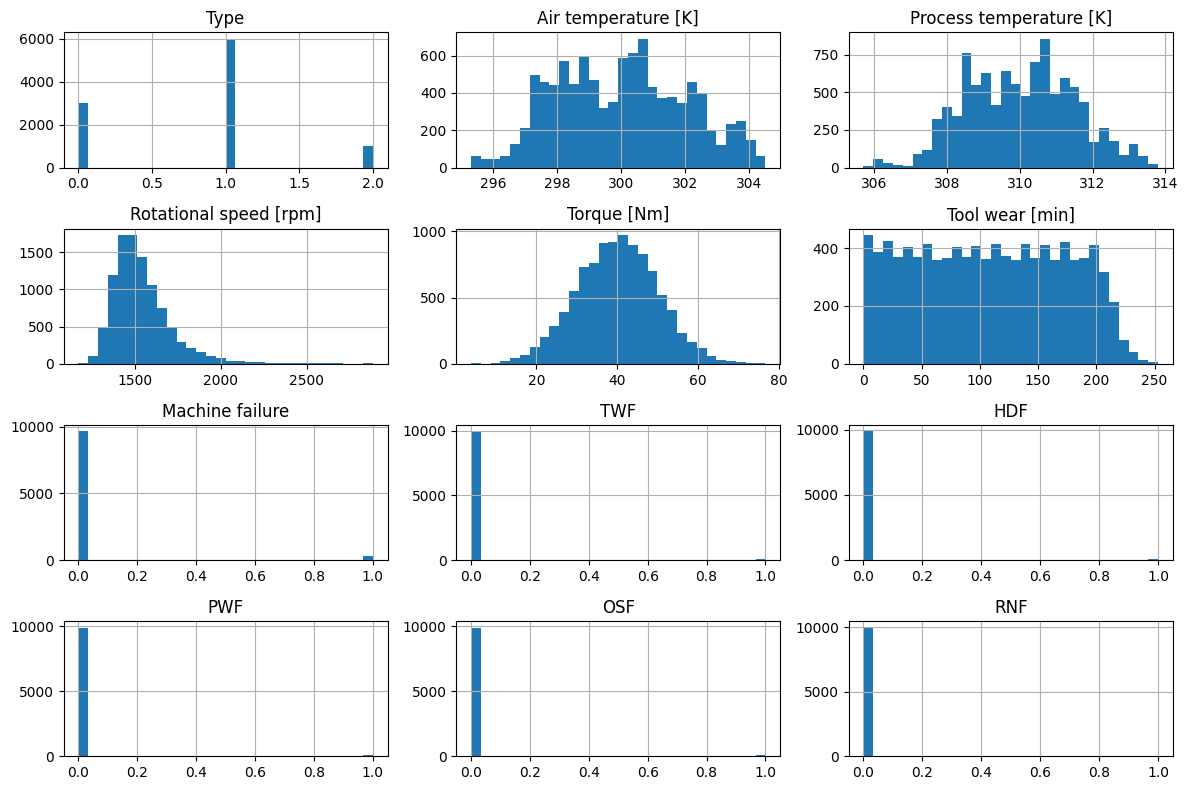

In [137]:
data.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Выводы из гистограмм:

Типы: первая категория существенно преобладает над остальными.

Температуры: относительно равномерны.

Скорость вращения и крутящий момент: показывают нормальные распределения с лёгкой асимметрией.

Износ инструмента: примерно равномерно покрывает весь интервал эксплуатации.

Режимы отказов (Machine failure, TWF, HDF, PWF, OSF, RNF): практически вся выборка находится в однотипном состоянии (нулевом уровне отказа).

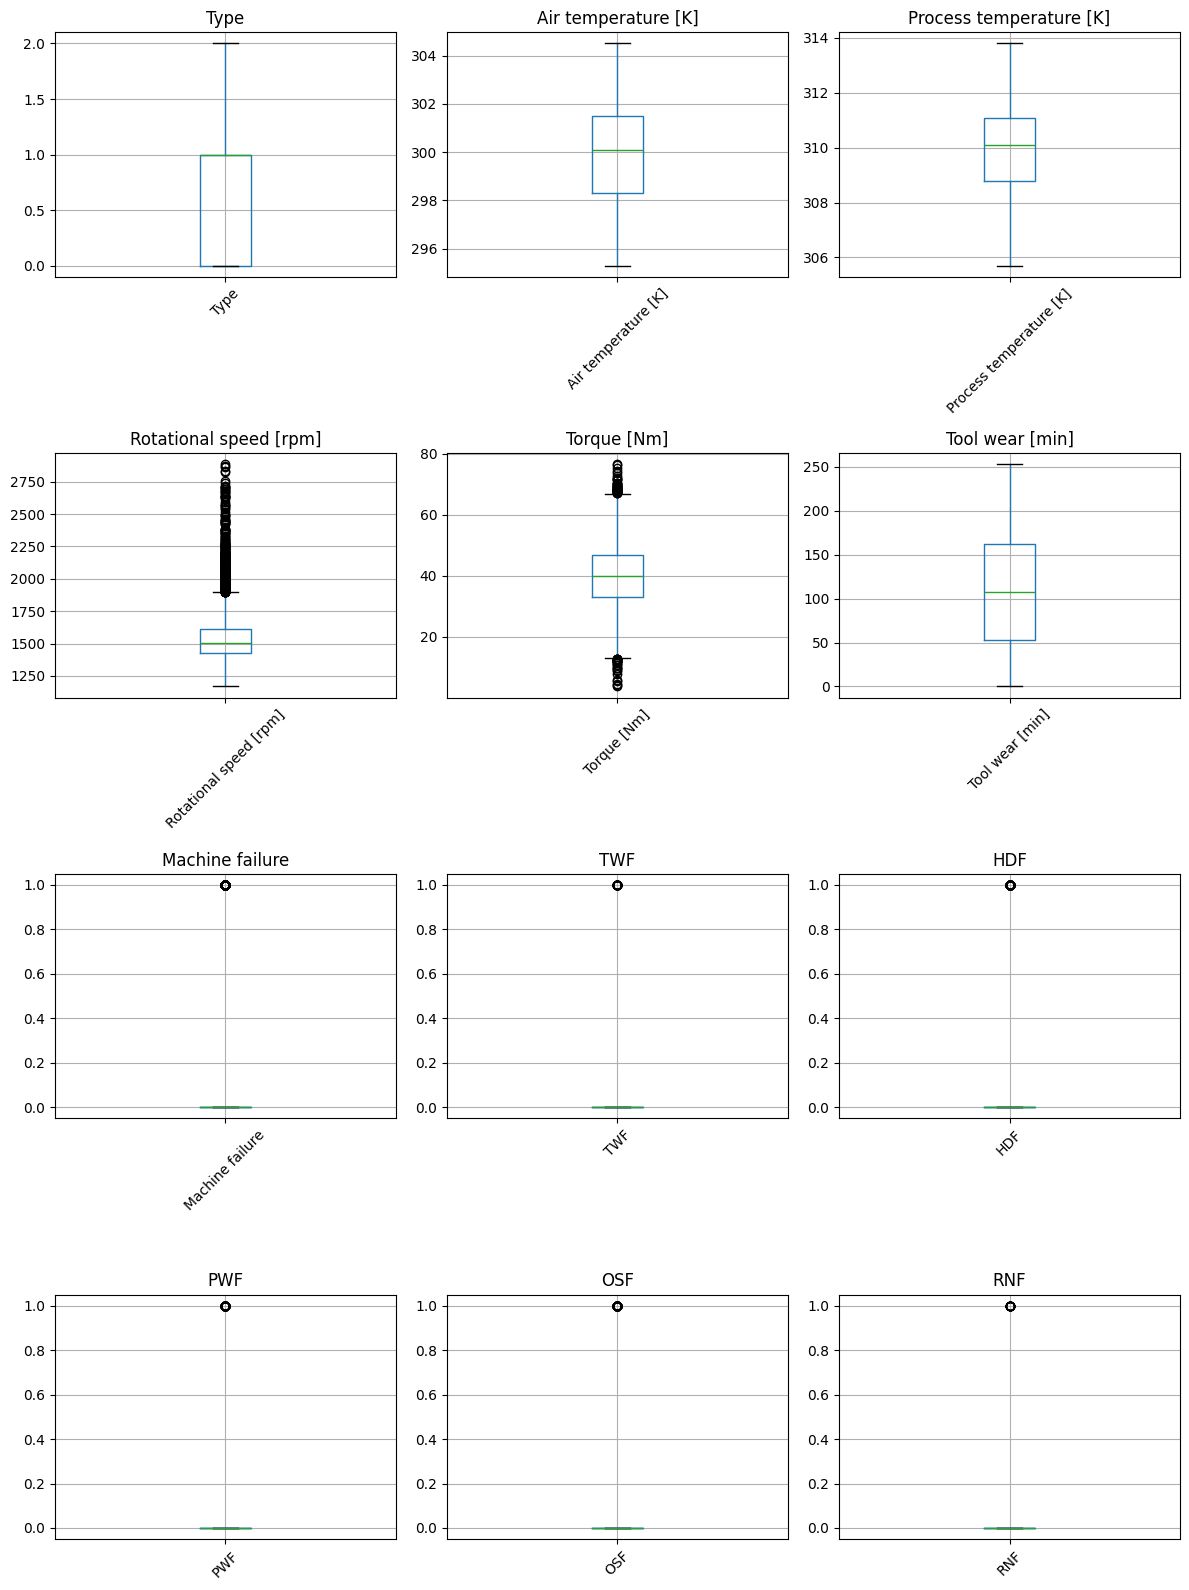

In [141]:
cols = data.columns
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, 4*rows))
for ax, col in zip(axes.flatten(), cols):
    data.boxplot(column=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

for ax in axes.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


Вывод: отдельные колонки показывают редкие выбросы, которые важны.

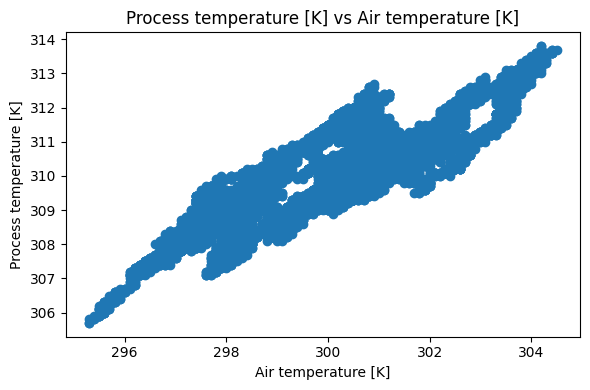

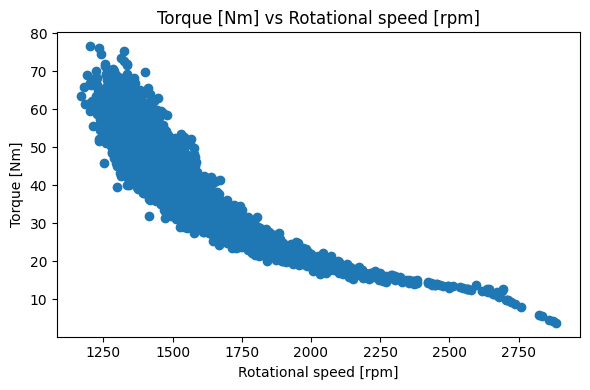

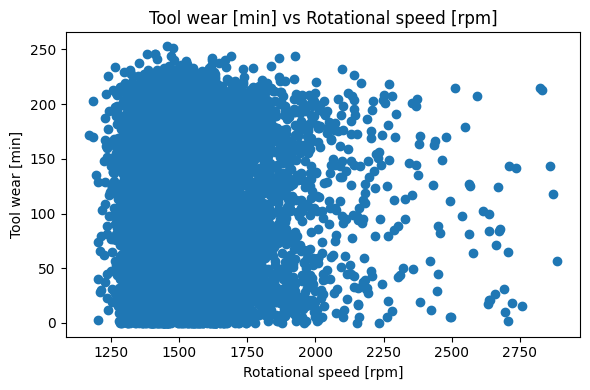

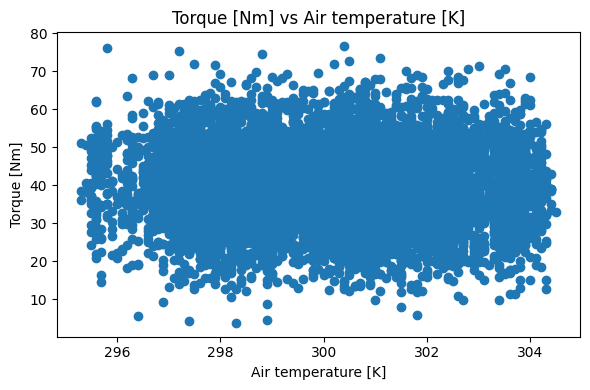

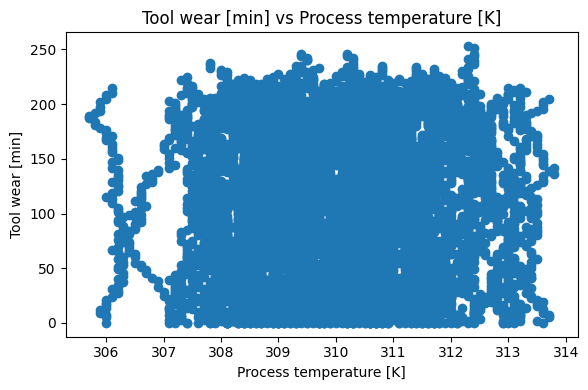

In [139]:
pairs = [
    ('Air temperature [K]', 'Process temperature [K]'),
    ('Rotational speed [rpm]', 'Torque [Nm]'),
    ('Rotational speed [rpm]', 'Tool wear [min]'),
    ('Air temperature [K]', 'Torque [Nm]'),
    ('Process temperature [K]', 'Tool wear [min]')
]

for x_col, y_col in pairs:
    plt.figure(figsize=(6, 4))
    plt.scatter(data[x_col], data[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{y_col} vs {x_col}')
    plt.tight_layout()
    plt.show()


Выводы из диаграмм рассеяния:

Температура процесса и температура воздуха: почти линейная прямая зависимость, с ростом температуры воздуха растёт и температура процесса

Крутящий момент и скорость вращения: отрицательная корреляция, при больших оборотах крутящий момент обычно меньше

Износ инструмента и скорость вращения: явной связи нет, износ встречается при любых скоростях вращения.

Крутящий момент и температура воздуха: без заметных зависимостей, температура воздуха на крутящий момент не влияет

Износ инструмента и температура процесса: без заметных зависимостей, износ не зависит от температуры процесса.

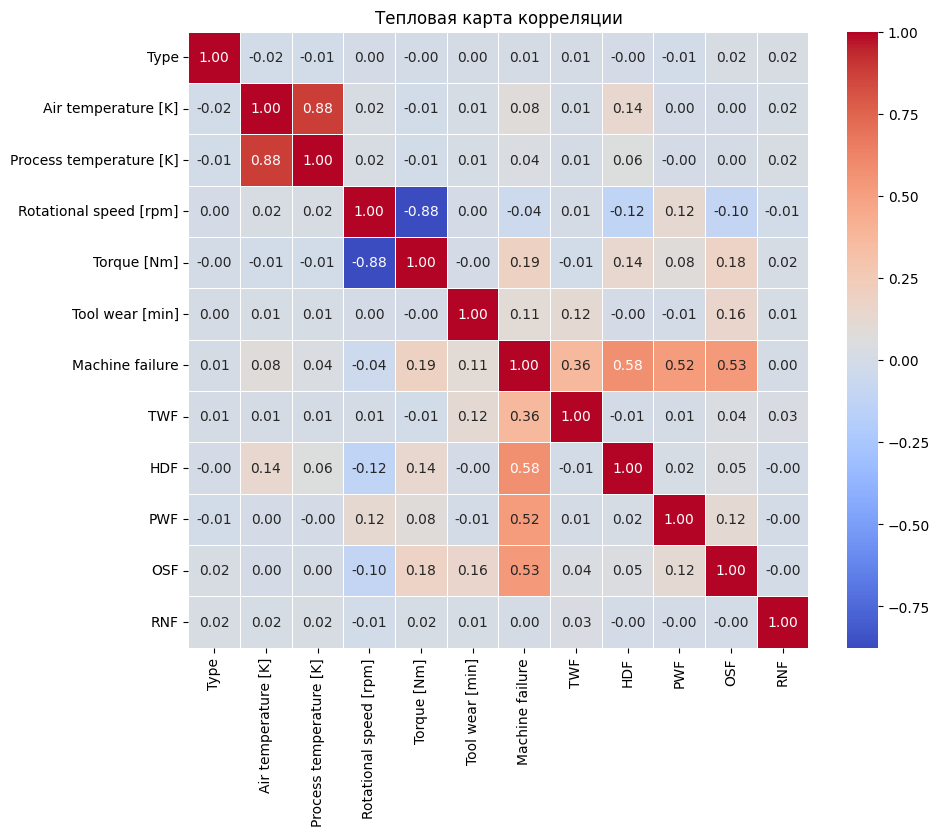

In [112]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.title('Тепловая карта корреляции')
plt.show()

Вывод: температура воздуха и температура процесса положительно коррелируют друг с другом, скорость вращения и крутящий момент отрицательно коррелируют друг с другом, как и показали графики парной зависимости, отказ машины в целом зависит от отказа из-за рассеивания тепла, отказа питания и отказа из-за перенапряжения

In [115]:
data = data.drop(columns=['Rotational speed [rpm]'])

Разделение на обучающую и тестовую выборки

In [116]:
y = data['Process temperature [K]']

X = data.drop(columns=['Process temperature [K]'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение

ElasticNet

In [117]:
param_distributions = {
    'alpha':    uniform(loc=1e-3, scale=10),
    'l1_ratio': uniform(loc=0,    scale=1)
}

rs = RandomizedSearchCV(
    estimator=ElasticNet(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print(rs.best_params_)


{'alpha': np.float64(0.05622117123602399), 'l1_ratio': np.float64(0.8154614284548342)}


In [118]:
best_params = {'alpha': 0.05622117123602399, 'l1_ratio': 0.8154614284548342}

model = ElasticNet(alpha=best_params['alpha'],
                   l1_ratio=best_params['l1_ratio'],
                   random_state=42)
model.fit(X_train, y_train)

print("Train MSE: ", mean_squared_error(y_train, model.predict(X_train)))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
print("Train MAE: ", mean_absolute_error(y_train, model.predict(X_train)))
print("Train R2:  ", r2_score(y_train, model.predict(X_train)))
print("Train MAPE:", f"{mean_absolute_percentage_error(y_train, model.predict(X_train)) * 100:.2f}")

print("Test MSE:  ", mean_squared_error(y_test, model.predict(X_test)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("Test MAE:  ", mean_absolute_error(y_test, model.predict(X_test)))
print("Test R2:   ", r2_score(y_test, model.predict(X_test)))
print("Test MAPE:", f"{mean_absolute_percentage_error(y_test, model.predict(X_test)) * 100:.2f}")

Train MSE:  0.507912908743907
Train RMSE: 0.7126800886399921
Train MAE:  0.5863064727587307
Train R2:   0.7701084954841141
Train MAPE: 0.19
Test MSE:   0.5293007438464952
Test RMSE:  0.7275305793205501
Test MAE:   0.5951010103332187
Test R2:    0.7559468699634704
Test MAPE: 0.19


переобучения нет, точность предсказания 76%, модель ошибается в 19% случаев

Дерево решений

In [119]:
param_distributions = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

rs = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print(rs.best_params_)


{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 12}


In [120]:
model = DecisionTreeRegressor(
    max_depth=6,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=12,
    random_state=42
).fit(X_train, y_train)

print("Train MSE: ", mean_squared_error(y_train, model.predict(X_train)))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
print("Train MAE: ", mean_absolute_error(y_train, model.predict(X_train)))
print("Train R2:  ", r2_score(y_train, model.predict(X_train)))
print("Train MAPE:", f"{mean_absolute_percentage_error(y_train, model.predict(X_train)) * 100:.2f}")

print("Test MSE:  ", mean_squared_error(y_test, model.predict(X_test)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("Test MAE:  ", mean_absolute_error(y_test, model.predict(X_test)))
print("Test R2:   ", r2_score(y_test, model.predict(X_test)))
print("Test MAPE:", f"{mean_absolute_percentage_error(y_test, model.predict(X_test)) * 100:.2f}")


Train MSE:  0.3918348509716514
Train RMSE: 0.6259671325011014
Train MAE:  0.4945094456515136
Train R2:   0.8226477377107784
Train MAPE: 0.16
Test MSE:   0.43100307963913326
Test RMSE:  0.656508247959714
Test MAE:   0.5218287597435731
Test R2:    0.8012705406818396
Test MAPE: 0.17


переобучения нет, точность предсказания 80%, модель ошибается в 17% случаев

CatBoost

In [121]:
param_distributions = {
    'depth': randint(4, 10),
    'learning_rate': uniform(loc=0.01, scale=0.29),
    'l2_leaf_reg': uniform(loc=1, scale=9)
}

rs = RandomizedSearchCV(
    estimator=CatBoostRegressor(random_state=42, verbose=0),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print(rs.best_params_)

{'depth': 7, 'l2_leaf_reg': np.float64(5.456592191001432), 'learning_rate': np.float64(0.019972671123413333)}


In [123]:
model = CatBoostRegressor(
    depth=7,
    l2_leaf_reg=5.456592191001432,
    learning_rate=0.019972671123413333,
    random_state=42,
    verbose=0
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

print("Train MSE: ", mean_squared_error(y_train, y_pred_train))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Train MAE: ", mean_absolute_error(y_train, y_pred_train))
print("Train R2:  ", r2_score(y_train, y_pred_train))
print("Train MAPE:", f"{mean_absolute_percentage_error(y_train, y_pred_train) * 100:.2f}%\n")

print("Test MSE:  ", mean_squared_error(y_test, y_pred_test))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MAE:  ", mean_absolute_error(y_test, y_pred_test))
print("Test R2:   ", r2_score(y_test, y_pred_test))
print("Test MAPE:", f"{mean_absolute_percentage_error(y_test, y_pred_test) * 100:.2f}%")

Train MSE:  0.3513845777198032
Train RMSE: 0.5927770050531677
Train MAE:  0.472534844109512
Train R2:   0.8409563375038873
Train MAPE: 0.15%

Test MSE:   0.4240136993027135
Test RMSE:  0.6511633430274723
Test MAE:   0.5213124514766225
Test R2:    0.8044932456712997
Test MAPE: 0.17%


можно заподозрить переобучение, точность предсказания 80%, модель ошибается в 17% случаев

Сравнение RMSE и R^2:

ElasticNet: R^2 =0.76.

DecisionTree: R^2 =0.80.

CatBoost: R^2 =0.80.

train/test:

для всех моделей разница между train и test невысока, признаков серьёзного переобучения нет

MAE и MAPE:

MAE =0.49–0.60, MAPE =0.16–0.19%


Вывод: метрики выглядят допустимо и показывают, что CatBoost даёт лучшее значение метрик

деплой

In [ ]:
new_data = pd.DataFrame([{
    'Type': 1,
    'Air temperature [K]': 299.5,
    'Rotational speed [rpm]': 1600,
    'Torque [Nm]': 45,
    'Tool wear [min]': 50,
    'Machine failure': 0,
    'TWF': 0,
    'HDF': 0,
    'PWF': 0,
    'OSF': 0,
    'RNF': 0
}])

print(model.predict(new_data))

[309.62584239]


Общий вывод: была произведена предобработка данных, препроцессингш категориального признака, удалены ненужные признаки. Для решения задачи было выбрано три модели ElasticNet, DecisionTree и CatBoost, и также были подобраны гиперпараметры. Вывелись метрики обученных моделей, в соответствии с метриками лучше всего себя показала модель CatBoost.